In this notebook we will perform finetuning on Bert for the states prediction task, mention in section 4.4 of our paper.

In [ ]:
import pandas as pd
df = pd.read_csv("combined_data_adam.csv")

/tmp/ipykernel_26223/89575442.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_data_adam.csv")


In [ ]:
caption_state_year = df[["caption_text_clean","year","state_name"]].dropna()
caption_state_year

,caption_text_clean,year,state_name
0,tell me when okay fellas were up good evening ...,2006,Texas
1,alright alright let welcome everybody we have ...,2006,Texas
2,your honor okay good afternoon will call to or...,2006,Texas
3,okay good afternoon we will call the city coun...,2006,Texas
4,okay we are up good afternoon we call to order...,2006,Texas
...,...,...,...
99184,roll call pledge of allegiance municipal court...,2018,Wyoming
99185,i now call the february th so i have cold medi...,2018,Wyoming
99186,we are and out i think it said and and then ha...,2018,Wyoming
99187,the council that i would like to get some of y...,2018,Wyoming


In [ ]:
year_state = caption_state_year[["year","state_name"]]

let's show tha class distribution:

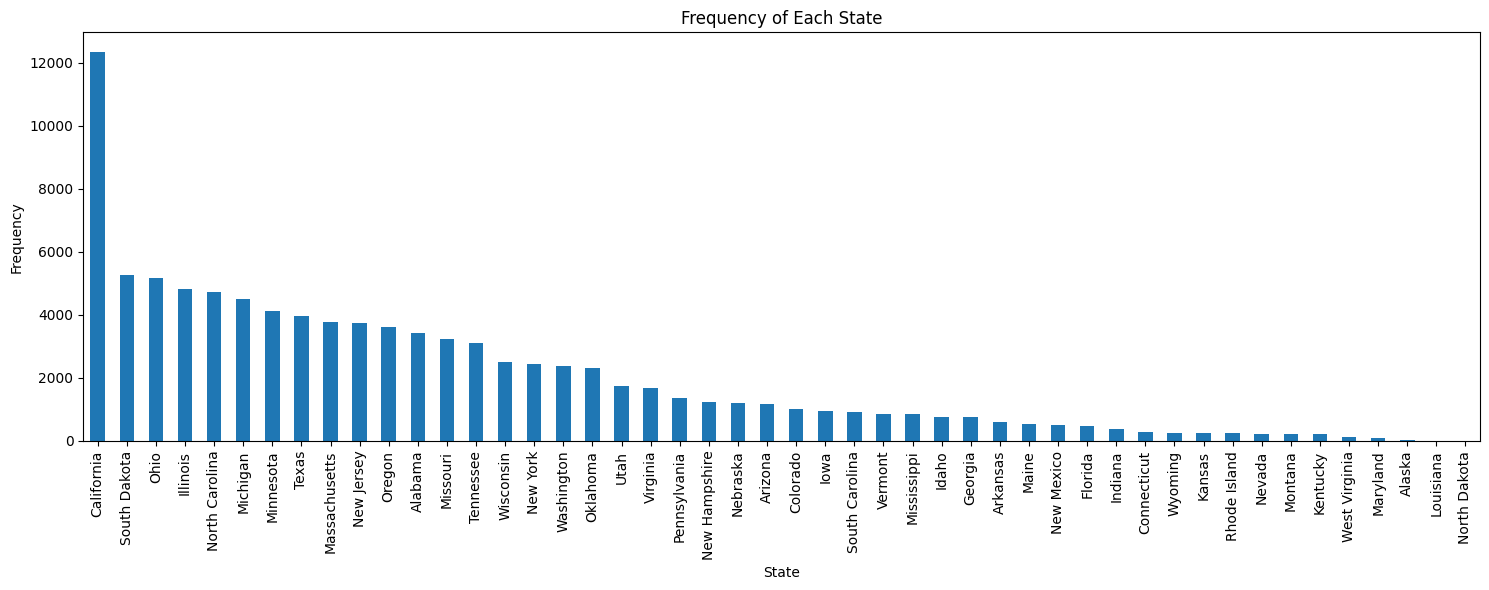

In [ ]:
import matplotlib.pyplot as plt

state_counts = year_state["state_name"].value_counts()
state_counts.plot(kind='bar', figsize=(15, 6))  # Increase the width of the figure
plt.title('Frequency of Each State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=10)  # Increase rotation to 90 degrees and reduce font size
plt.tight_layout()
plt.show()


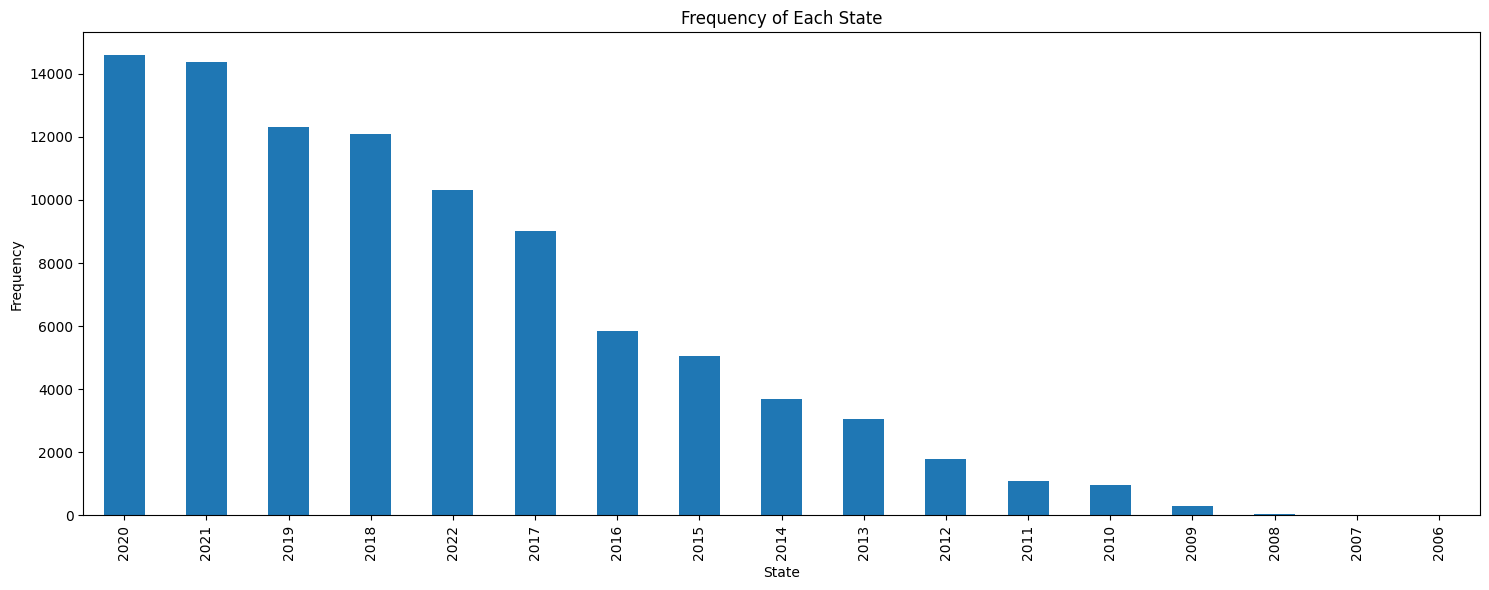

In [ ]:
import matplotlib.pyplot as plt

state_counts = year_state["year"].value_counts()
state_counts.plot(kind='bar', figsize=(15, 6))  # Increase the width of the figure
plt.title('Frequency of Each State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=10)  # Increase rotation to 90 degrees and reduce font size
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
train = caption_state_year[caption_state_year.year.isin([2020,2021])]
test = caption_state_year[caption_state_year.year == 2022]
print(train.shape)
print(test.shape)


(28946, 3)
(10308, 3)


In [ ]:
print(len(train.state_name.drop_duplicates()))
print(len(test.state_name.drop_duplicates()))

47
45


In [ ]:
train.state_name.value_counts()

state_name
California        3491
North Carolina    1593
Massachusetts     1551
Ohio              1453
South Dakota      1416
New Jersey        1399
Tennessee         1353
Michigan          1271
Illinois          1223
Missouri          1142
Minnesota         1090
Oregon            1042
Texas              985
Alabama            942
Wisconsin          875
Oklahoma           748
Washington         724
Utah               618
New York           521
Virginia           475
Arizona            441
Vermont            403
Idaho              372
Pennsylvania       372
Iowa               333
New Hampshire      316
Mississippi        307
South Carolina     292
Colorado           292
Nebraska           263
Georgia            222
New Mexico         199
Maine              188
Arkansas           150
Florida            147
Indiana            132
Connecticut        119
Kansas              88
Nevada              79
Wyoming             67
Rhode Island        61
West Virginia       58
Kentucky            47


In [ ]:
test.state_name.value_counts()

state_name
California        885
North Carolina    634
New Jersey        575
South Dakota      554
Michigan          517
Illinois          485
Massachusetts     466
Ohio              437
Texas             411
Minnesota         374
Oregon            369
Alabama           360
Washington        351
Wisconsin         317
Tennessee         315
Missouri          298
Utah              249
Oklahoma          245
Colorado          227
New York          219
Virginia          209
Vermont           180
Pennsylvania      166
Arizona           155
Mississippi       125
Georgia           115
Nebraska          111
New Mexico        108
New Hampshire     100
South Carolina     88
Idaho              84
Maine              67
Arkansas           66
Florida            66
Iowa               64
Nevada             60
Rhode Island       52
Kansas             41
Connecticut        34
Indiana            31
West Virginia      28
Montana            20
Wyoming            19
Kentucky           17
Maryland           14

In [ ]:
def is_subset(list1, list2):
    return set(list1).issubset(set(list2))
is_subset(test.state_name, train.state_name)

True

In [ ]:
test

,caption_text_clean,year,state_name
63098,everybody we are gonna go ahead and get starte...,2022,Alabama
63099,to the city council works session for septembe...,2022,Alabama
63100,good evening i would like to call the city of ...,2022,Alabama
63101,good evening everybody we are gonna go ahead a...,2022,Alabama
63102,uh kevin can join us when he gets here um welc...,2022,Alabama
...,...,...,...
73401,yeah so let go ahead and get started with our ...,2022,Wyoming
73402,okay let go ahead and get started with our pre...,2022,Wyoming
73403,schedule just a little bit and so i want to pl...,2022,Wyoming
73404,um this facility yet could we get you to turn ...,2022,Wyoming


In [ ]:
import pandas as pd


# Find states that appear less than 100 times in the train dataframe
infrequent_states = train['state_name'].value_counts()
infrequent_states = infrequent_states[infrequent_states < 100].index.tolist()

# Filter out these states from the train dataframe
train = train[~train['state_name'].isin(infrequent_states)]

# Filter out these states from the test dataframe
test = test[~test['state_name'].isin(infrequent_states)]

print(train.shape)
print(test.shape)


(28460, 3)
(10057, 3)


In [ ]:
print(len(train.state_name.drop_duplicates()))
print(len(test.state_name.drop_duplicates()))

37
37


In [ ]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train.to_csv("train_states.csv", index = False)
test.to_csv("test_states.csv", index = False)

In [ ]:
train = pd.read_csv("train_states.csv")
test = pd.read_csv("test_states.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.caption_text_clean
        self.targets = dataframe.state_name.values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [ ]:
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=train.state_name.nunique()).to('cuda')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
encoder = LabelEncoder()
train['state_name'] = encoder.fit_transform(train['state_name'])
test['state_name'] = encoder.transform(test['state_name'])

MAX_LEN = 256  # Change if necessary
train_dataset = CustomDataset(train, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


We ran the following training code on ISE's GPU cluster:

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    logging_first_step=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


In [ ]:
def compute_roc_auc(model, data_loader):
    model.eval()
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask)[0]
            all_outputs.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.detach().cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate 1 vs All ROC AUC for each class
    roc_auc_scores = []
    for i in range(all_outputs.shape[1]):
        roc_auc = roc_auc_score((all_targets == i).astype(int), all_outputs[:, i])
        roc_auc_scores.append(roc_auc)

    return np.mean(roc_auc_scores)  # You can also return per class scores if necessary

roc_auc_avg = compute_roc_auc(model, test_loader)
print(f"Average 1 vs All ROC AUC: {roc_auc_avg}")


**logs during training:**

{'loss': 3.3128, 'learning_rate': 4.531572044219599e-05, 'epoch': 0.28}
{'loss': 2.1718, 'learning_rate': 4.063144088439198e-05, 'epoch': 0.56}
{'loss': 1.3947, 'learning_rate': 3.594716132658797e-05, 'epoch': 0.84}

{'eval_loss': 1.132539987564087, 'eval_runtime': 1280.6171, 'eval_samples_per_second': 7.853, 'eval_steps_per_second': 0.491, 'epoch': 1.0}
{'loss': 0.9811, 'learning_rate': 3.1262881768783965e-05, 'epoch': 1.12}
{'loss': 0.7238, 'learning_rate': 2.657860221097995e-05, 'epoch': 1.41}
{'loss': 0.6575, 'learning_rate': 2.189432265317594e-05, 'epoch': 1.69}
{'loss': 0.6018, 'learning_rate': 1.7210043095371933e-05, 'epoch': 1.97}

{'eval_loss': 0.8191031813621521, 'eval_runtime': 1280.9188, 'eval_samples_per_second': 7.851, 'eval_steps_per_second': 0.491, 'epoch': 2.0}
{'loss': 0.3587, 'learning_rate': 1.2525763537567922e-05, 'epoch': 2.25}
{'loss': 0.3088, 'learning_rate': 7.841483979763913e-06, 'epoch': 2.53}
{'loss': 0.3178, 'learning_rate': 3.157204421959903e-06, 'epoch': 2.81}

{'eval_loss': 0.7648079991340637, 'eval_runtime': 1283.2679, 'eval_samples_per_second': 7.837, 'eval_steps_per_second': 0.49, 'epoch': 3.0}
{'train_runtime': 15001.0459, 'train_samples_per_second': 5.692, 'train_steps_per_second': 0.356, 'train_loss': 1.0308999241526395, 'epoch': 3.0}

The following code was used after the training process finished in ISE's GPU cluster.

In [ ]:
from transformers import BertForSequenceClassification

MODEL_DIR = '/sise/home/adamu/master_courses/miki/results/checkpoint-5337/'
model = BertForSequenceClassification.from_pretrained(MODEL_DIR).to('cuda')


In [ ]:
from tqdm import tqdm

predictions, true_labels, prediction_probs = [], [], []

# Wrap test_loader with tqdm for a progress bar
for batch in tqdm(test_loader, desc="Evaluating"):
    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['labels'].to('cuda')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)[0]

    # Get the predicted probabilities
    softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
    probs = softmax_outputs.detach().cpu().numpy()

    # Get the predicted class
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    predictions.extend(preds)
    prediction_probs.extend(probs)
    true_labels.extend(labels)


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/adamu/.conda/envs/pytorch_gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Evaluating: 100%|████████

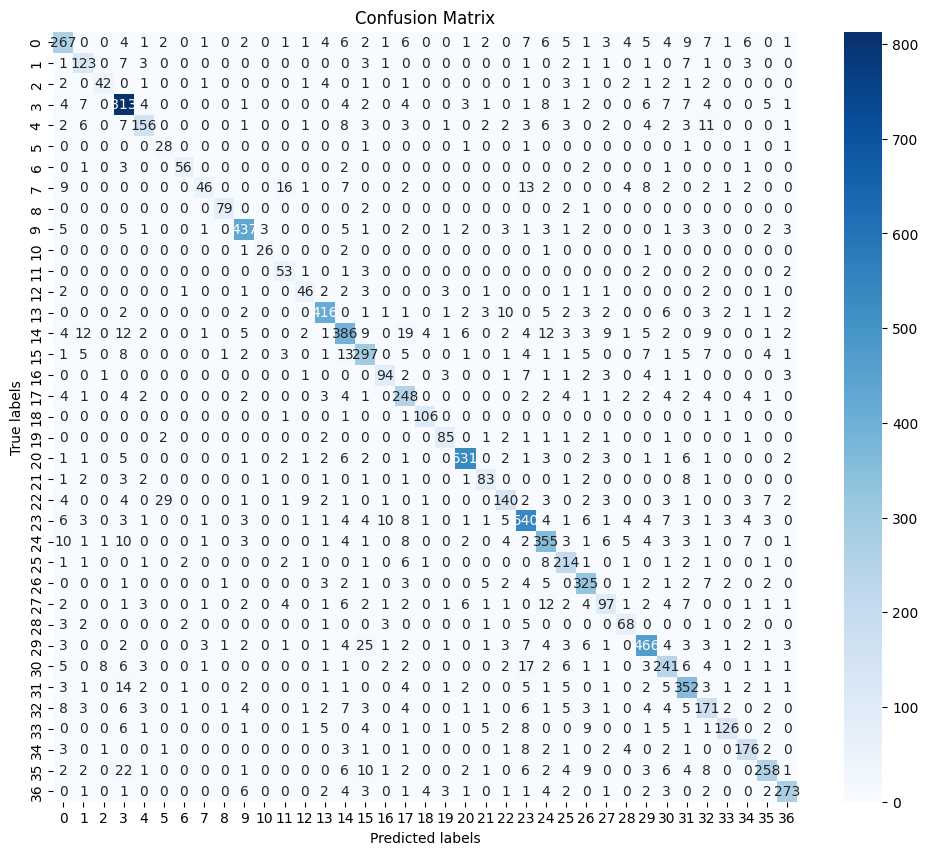

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_1vsall_roc_auc(prediction_probs, true_labels):
    prediction_probs = np.array(prediction_probs)
    true_labels = np.array(true_labels)

    # Calculate 1 vs All ROC AUC for each class
    roc_auc_scores = []
    for i in range(prediction_probs.shape[1]):
        roc_auc = roc_auc_score((true_labels == i).astype(int), prediction_probs[:, i])
        roc_auc_scores.append(roc_auc)

    return np.mean(roc_auc_scores)  # You can also return per class scores if necessary

roc_auc_avg = compute_1vsall_roc_auc(prediction_probs, true_labels)
print(f"Average 1 vs All ROC AUC: {roc_auc_avg}")


Average 1 vs All ROC AUC: 0.9829615814440863


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score & Support
report = classification_report(true_labels, predictions, target_names=encoder.classes_)
print(report)




Accuracy: 0.8173
                precision    recall  f1-score   support

       Alabama       0.76      0.74      0.75       360
       Arizona       0.72      0.79      0.75       155
      Arkansas       0.79      0.64      0.71        66
    California       0.86      0.92      0.89       885
      Colorado       0.83      0.69      0.75       227
   Connecticut       0.45      0.82      0.58        34
       Florida       0.89      0.85      0.87        66
       Georgia       0.81      0.40      0.53       115
         Idaho       0.95      0.94      0.95        84
      Illinois       0.91      0.90      0.91       485
       Indiana       0.87      0.84      0.85        31
          Iowa       0.63      0.83      0.72        64
         Maine       0.68      0.69      0.68        67
 Massachusetts       0.91      0.89      0.90       466
      Michigan       0.79      0.75      0.77       517
     Minnesota       0.77      0.79      0.78       374
   Mississippi       0.81     

In [ ]:
# Compute class-wise accuracy from the confusion matrix
class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
for i, class_name in enumerate(encoder.classes_):
    print(f"Accuracy for class {class_name}: {class_accuracy[i]:.4f}")


Accuracy for class Alabama: 0.7417
Accuracy for class Arizona: 0.7935
Accuracy for class Arkansas: 0.6364
Accuracy for class California: 0.9186
Accuracy for class Colorado: 0.6872
Accuracy for class Connecticut: 0.8235
Accuracy for class Florida: 0.8485
Accuracy for class Georgia: 0.4000
Accuracy for class Idaho: 0.9405
Accuracy for class Illinois: 0.9010
Accuracy for class Indiana: 0.8387
Accuracy for class Iowa: 0.8281
Accuracy for class Maine: 0.6866
Accuracy for class Massachusetts: 0.8927
Accuracy for class Michigan: 0.7466
Accuracy for class Minnesota: 0.7941
Accuracy for class Mississippi: 0.7520
Accuracy for class Missouri: 0.8322
Accuracy for class Nebraska: 0.9550
Accuracy for class New Hampshire: 0.8500
Accuracy for class New Jersey: 0.9235
Accuracy for class New Mexico: 0.7685
Accuracy for class New York: 0.6393
Accuracy for class North Carolina: 0.8517
Accuracy for class Ohio: 0.8124
Accuracy for class Oklahoma: 0.8735
Accuracy for class Oregon: 0.8808
Accuracy for class P